In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

benchmark = pd.read_csv('/Users/jiaqizhang/Documents/innovation_day/stock/data/000905.SH.CSV')

In [27]:
benchmark.head()

,code,short_name,transaction_date,pre_close,open,high,low,close,vol,amount,diff,gain
0,000905.SH,zz500,2011-01-04,4936.716,4964.214,5012.057,4938.942,5011.498,3699564400,54148801363,74.782,1.5148
1,000905.SH,zz500,2011-01-05,5011.498,4989.105,5038.872,4964.866,5028.766,3475221800,52016619203,17.268,0.3446
2,000905.SH,zz500,2011-01-06,5028.766,5026.331,5047.259,4992.165,5001.283,3123874300,45887129031,-27.483,-0.5465
3,000905.SH,zz500,2011-01-07,5001.283,4990.698,5028.274,4945.784,4975.144,3499623300,47227223346,-26.139,-0.5226
4,000905.SH,zz500,2011-01-10,4975.144,4966.563,4970.422,4816.581,4830.562,3113786200,43833176246,-144.582,-2.9061


In [153]:
#benchmark_gain = np.cumsum(benchmark['gain'])
#benchmark_gt = benchmark[['transaction_date', 'code', 'gain']]
#benchmark_gt.dtypes()
bg = benchmark[['transaction_date', 'code', 'close', 'gain']]
bg['tran_date'] = pd.to_datetime(bg['transaction_date'])
bg=bg.drop(['transaction_date'],1)
bg = bg.rename(columns = {'tran_date':'transaction_date'})
bg['out_date'] = bg.transaction_date + pd.Timedelta('7 days')
bg_r = bg.drop(['out_date', 'gain'], 1)
bg_r = bg_r.rename(columns = {'transaction_date':'out_date'})
bgn = bg.join(bg_r.set_index(['code', 'out_date']), 
                               on=['code', 'out_date'], rsuffix='_7d')
bgn_since_2015 = bgn[bgn.transaction_date > pd.to_datetime('2015-01-01')].reset_index()

bgn_since_2016 = bgn[bgn.transaction_date > pd.to_datetime('2016-01-01')].reset_index()



/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:
bgn_since_2015.gain.describe()

count    456.000000
mean       0.079769
std        2.478087
min       -8.539500
25%       -0.792900
50%        0.324450
75%        1.410450
max        6.601300
Name: gain, dtype: float64

In [154]:
bgn2015 = bgn_since_2015[['transaction_date', 'gain']]
bgn2015['cum_gain'] = np.cumsum(bgn_since_2015.gain) / 100.0
bgn2015['cum_prod'] = np.cumprod(1.0+(bgn_since_2015.gain/100.0))

bgn2016 =bgn_since_2016[['transaction_date', 'gain']]
bgn2016['cum_gain'] = np.cumsum(bgn_since_2016.gain) / 100.0
bgn2016['cum_prod'] = np.cumprod(1.0+(bgn_since_2016.gain/100.0))


/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [21]:
oot_scores = pd.HDFStore('/Users/jiaqizhang/Documents/innovation_day/stock/data/oot_scores.h5')
no_ipo_limit = oot_scores['no_ipo_limit']
oot_scores.close()

In [164]:
keep_vars = ['code', 'transaction_date', 'predict', 'close', 'close_7d', 'gain', 'days_since_ipo']
select_code = no_ipo_limit[ (no_ipo_limit.predict > 0.7) & (no_ipo_limit.days_since_ipo > 180) ]

In [36]:
select_code_gain = select_code[['transaction_date', 'gain']].groupby('transaction_date').mean()

In [57]:
select_code_gain['cum_gain'] = np.cumsum(select_code_gain.gain)
select_code_gain['gain'].describe()

count    81.000000
mean      0.059402
std       0.100038
min      -0.176710
25%       0.000000
50%       0.030161
75%       0.112475
max       0.375736
Name: gain, dtype: float64

# a lot of gain is over 0.6

In [63]:
oot_scores = pd.HDFStore('/Users/jiaqizhang/Documents/innovation_day/stock/data/gbt_scores.h5')
gbt_scores = oot_scores['gbt_scores']
oot_scores.close()

In [80]:
# tag 涨停股
gbt_scores_p = gbt_scores[['code','transaction_date', 'close']]
gbt_scores_p['pre_date'] = gbt_scores_p.transaction_date + pd.Timedelta('1 days')
gbt_scores_p = gbt_scores_p.drop(['transaction_date'], 1)
gbt_scores_p = gbt_scores_p.rename(columns = {'pre_date':'transaction_date','close':'p_close'})
gbt_scores_a = gbt_scores.join(gbt_scores_p.set_index(['code', 'transaction_date']), 
                               on=['code', 'transaction_date'])
gbt_scores_a['daily_gain'] = (gbt_scores_a['close'] - gbt_scores_a['p_close']) / gbt_scores_a['close']
gbt_scores_a.head()

/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,code,transaction_date,close,close_7d,predict,tag,swing,days_since_ipo,turn,vol,amount,low,high,open,pb,mkt_cap,pe,gain,p_close,daily_gain
0,000001.sz,2015-01-05,10.87,10.02,0.189915,1,4.29,8678.0,2.91,286043643.0,4.565388e+09,10.58,11.04,10.85,1.444158,1.830268e+11,11.662216,-0.078197,NaN,NaN
1,000001.sz,2015-01-06,10.70,9.96,0.151349,0,5.24,8679.0,2.20,216642140.0,3.453446e+09,10.55,11.12,10.75,1.422523,1.802848e+11,11.487501,-0.069159,10.87,-0.015888
2,000001.sz,2015-01-07,10.50,10.05,0.168613,0,3.36,8680.0,1.73,170012067.0,2.634796e+09,10.38,10.74,10.55,1.395479,1.768574e+11,11.269107,-0.042857,10.70,-0.019048
3,000001.sz,2015-01-08,10.15,10.41,0.329826,0,4.33,8681.0,1.43,140771421.0,2.128003e+09,10.11,10.56,10.51,1.348602,1.709164e+11,10.890559,0.025616,10.50,-0.034483
4,000001.sz,2015-01-09,10.23,10.42,0.481323,0,7.75,8682.0,2.55,250850023.0,3.835378e+09,9.98,10.76,10.11,1.359420,1.722874e+11,10.977916,0.018573,10.15,0.007820


In [156]:
keep_vars = ['code', 'transaction_date', 'predict', 'close', 'close_7d', 'gain', 'days_since_ipo']
select_code = gbt_scores_a[ (gbt_scores_a.predict > 0.7) & (gbt_scores_a.days_since_ipo > 180)
                         & (gbt_scores_a.daily_gain < 0.095) & (gbt_scores_a.daily_gain.notnull())
                          & (gbt_scores_a.transaction_date > pd.to_datetime('2016-01-01'))]
select_code['weekday'] = select_code.transaction_date.dt.dayofweek

select_code[select_code.weekday == 3][['transaction_date', 'gain']].groupby('transaction_date').count().describe()

#select_code_gain = select_code[select_code.weekday == 3][['transaction_date', 'gain']].groupby('transaction_date').mean()
#select_code_gain['cum_gain'] = np.cumsum(select_code_gain.gain)
#select_code_gain['gain'].describe()

/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gain
count,36.000000
mean,11.333333
std,3.295018
min,6.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,21.000000


In [157]:
select_code_gain = select_code[select_code.weekday == 3][['transaction_date', 'gain']].groupby('transaction_date').mean()
select_code_gain['cum_gain'] = np.cumsum(select_code_gain.gain)
select_code_gain['gain'].describe()

count    36.000000
mean      0.007488
std       0.026573
min      -0.045831
25%      -0.009270
50%       0.004479
75%       0.019829
max       0.064690
Name: gain, dtype: float64

In [158]:
select_code_gain['cum_prod'] = np.cumprod((1.0+select_code_gain.gain))
select_code_gain

,gain,cum_gain,cum_prod
transaction_date,,,
2016-01-07,-0.031480,-0.031480,0.968520
2016-01-14,-0.024208,-0.055688,0.945074
2016-01-21,-0.045831,-0.101519,0.901760
2016-01-28,0.050172,-0.051347,0.947004
2016-02-18,-0.007251,-0.058598,0.940137
2016-02-25,0.036280,-0.022318,0.974245
2016-03-03,-0.005170,-0.027489,0.969208
2016-03-10,0.055112,0.027624,1.022623
2016-03-17,0.019002,0.046625,1.042054


In [159]:
select_code[select_code.weekday == 3][['transaction_date', 'gain']].groupby('transaction_date').count().describe()

,gain
count,36.000000
mean,11.333333
std,3.295018
min,6.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,21.000000


In [162]:


result = select_code_gain.reset_index()
result = result.rename(columns = {'cum_gain':'gbdt_c_gain', 'cum_prod':'gbdt_c_prod'})
result=result.drop(['gain'], 1)
result = result.join(bgn2016.set_index(['transaction_date']), on=['transaction_date'], how='left')
result = result.rename(columns = {'cum_gain':'bench_gain', 'cum_prod':'bench_prod'})
result=result.drop(['gain'], 1)

result['diff_gain'] = result['gbdt_c_gain'] - result['bench_gain']

result


,transaction_date,gbdt_c_gain,gbdt_c_prod,bench_gain,bench_prod,diff_gain
0,2016-01-07,-0.031480,0.968520,-0.156546,0.848320,0.125066
1,2016-01-14,-0.055688,0.945074,-0.206489,0.804027,0.150801
2,2016-01-21,-0.101519,0.901760,-0.243718,0.772793,0.142199
3,2016-01-28,-0.051347,0.947004,-0.349966,0.691974,0.298619
4,2016-02-18,-0.058598,0.940137,-0.225129,0.782013,0.166531
5,2016-02-25,-0.022318,0.974245,-0.278726,0.738551,0.256408
6,2016-03-03,-0.027489,0.969208,-0.249267,0.758364,0.221778
7,2016-03-10,0.027624,1.022623,-0.293303,0.724885,0.320927
8,2016-03-17,0.046625,1.042054,-0.252335,0.754293,0.298960
9,2016-03-24,0.071736,1.068221,-0.204914,0.790059,0.276650


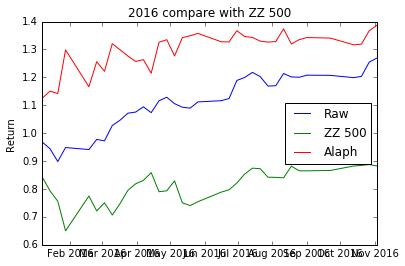

In [166]:

# plot curves and vertical lines for best iterations
plt.plot(result['transaction_date'], 1+result['gbdt_c_gain'], label='Raw')
plt.plot(result['transaction_date'], 1+result['bench_gain'], label='ZZ 500')
plt.plot(result['transaction_date'], 1+result['diff_gain'], label='Alaph')

plt.ylabel('Return ')
plt.title('2016 compare with ZZ 500')
plt.legend(loc="right")

plt.show()

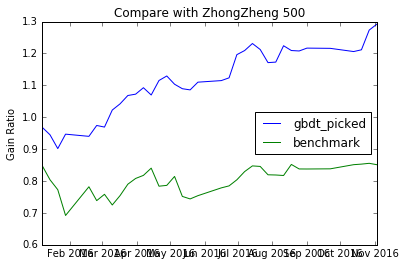

In [163]:
# plot curves and vertical lines for best iterations
plt.plot(result['transaction_date'], result['gbdt_c_prod'], label='gbdt_picked')
plt.plot(result['transaction_date'], result['bench_prod'], label='benchmark')

plt.ylabel('Gain Ratio')
plt.title('Compare with ZhongZheng 500')
plt.legend(loc="right")

plt.show()